## Multi-agent workflow to analyze earnings announcements ##

Workflow:
1. 

Recap
1. Define the Graph state in a TypedDict structure (include fields for messages, current steps, and final output)
2. Agent creation:
- Document Handler: Processes PDF, creates vectorstore
- Financial Parser: Extracts key metrics
- Credit Analyst: Analyzes credit metrics
- Industry Expert: Provides sector context
- Summary: Creates final credit comment

3. Workflow:
    > Create Graph instance
    > Add nodes for each agent
    > Define edged between the nodes
4. State management
    > Pass ststae between agents
    > Maintain conversation history in the messages list
    > 


In [66]:
from langchain_core.messages import HumanMessage
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from typing import TypedDict, Dict, Optional, List
from pathlib import Path
from datetime import datetime
import os 
import dotenv

#Load the .env file
dotenv.load_dotenv()

#Access API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"

# State Definition
class EarningsAnalysisState(TypedDict):
    ticker: str
    industry: str
    documents: Dict[str, str]
    document_analysis: Optional[str]
    financial_analysis: Optional[str]
    credit_analysis: Optional[str]
    industry_analysis: Optional[str]
    final_comment: Optional[str]
    status: str
    errors: List[str]

Document Handler Agent

Agent will take in earnings report PDF and will vectorize the document into FAISS vectorstore

In [53]:
def document_handler_agent(state: EarningsAnalysisState) -> EarningsAnalysisState:
    """
    Document handler agent with RAG capabilities:
    1. Loads PDF documents
    2. Splits them into chunks
    3. Creates vector embeddings
    4. Stores in FAISS for efficient retrieval
    """
    try:
        print(f"Processing documents for {state['ticker']}...")
        
        # Get document path
        earnings_path = Path(input("Please enter the path to the earnings release PDF: ").strip('"'))
        
        # Validate file exists
        if not earnings_path.exists():
            raise FileNotFoundError(f"File not found: {earnings_path}")
            
        state['documents'] = {
            "earnings_release": str(earnings_path)
        }
        
        # Process documents
        documents = {}
        embeddings = OpenAIEmbeddings()
        
        for doc_type, file_path in state['documents'].items():
            print(f"\nProcessing {doc_type}...")
            
            # Load PDF
            loader = PyPDFLoader(file_path)
            pages = loader.load()
            print(f"Successfully loaded {len(pages)} pages")
            
            # Split into chunks
            text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len,
            )
            chunks = text_splitter.split_documents(pages)
            print(f"Created {len(chunks)} text chunks")
            
            # Create vector store
            vectorstore = FAISS.from_documents(chunks, embeddings)
            documents[doc_type] = vectorstore
            print(f"Successfully processed {doc_type}")
        
        state['document_analysis'] = documents
        state['status'] = 'financial_analysis_needed'
        print("\nDocument processing completed successfully!")
        
    except Exception as e:
        state['errors'].append(f"Document processing error: {str(e)}")
        state['status'] = 'error'
        print(f"Error in document processing: {str(e)}")
    
    return state

Financial Parser Agent

Will use the vector store to find and analyze financial information in the document

In [54]:
from langchain.chains import create_qa_with_sources_chain
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import List, Dict

def financial_parser_agent(state: EarningsAnalysisState) -> EarningsAnalysisState:
    """
    Financial Parser agent that:
    1. Uses RAG to find relevant financial information
    2. Analyzes key metrics and trends
    3. Structures the findings for further analysis
    """
    try:
        print(f"\nAnalyzing financial information for {state['ticker']}...")
        
        # Get vector store from state
        vectorstore = state['document_analysis']['earnings_release']
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

        # Define key metrics we want to analyze
        analysis_queries = [
            "What was the revenue and revenue growth in the most recent quarter?",
            "What were the EBITDA and EBITDA margins?",
            "What was mentioned about traffic or operational metrics?",
            "What is the company's guidance or outlook?",
            "What are the key balance sheet metrics and leverage ratios?"
        ]

        # Collect findings for each query
        findings = {}
        for query in analysis_queries:
            print(f"\nAnalyzing: {query}")
            
            # Get relevant document chunks
            relevant_docs = vectorstore.similarity_search(query, k=3)
            
            # Combine relevant text
            context = "\n\n".join(doc.page_content for doc in relevant_docs)
            
            # Create analysis prompt
            prompt = f"""
            Based on the following context, answer the query: {query}
            
            Only include information that is explicitly stated in the context.
            If the information is not available, say "Information not found."
            
            Context:
            {context}
            """
            
            # Get LLM response
            response = llm.invoke([HumanMessage(content=prompt)])
            findings[query] = response.content

        # Create comprehensive analysis
        analysis_prompt = f"""
        Create a credit financial analysis for {state['ticker']} based on these findings:
        
        {findings}
        
        Format the analysis as follows:
        1. Revenue Performance
        2. Profitability (EBITDA/margins)
        3. Operational Metrics
        4. Forward Guidance
        5. Balance Sheet & Leverage
        
        Be concise and focus on key metrics and their changes.
        """
        
        final_analysis = llm.invoke([HumanMessage(content=analysis_prompt)])
        
        # Update state
        state['financial_analysis'] = final_analysis.content
        state['status'] = 'parallel_analysis_needed'
        print("\nFinancial analysis completed successfully!")
        
    except Exception as e:
        state['errors'].append(f"Financial analysis error: {str(e)}")
        state['status'] = 'error'
        print(f"Error in financial analysis: {str(e)}")
    
    return state

Create Credit analyst agent and Industry analyst agent who will work in parralel

Credit analyst agent - will focus on leverage, coverage ratios, and financial health

In [55]:
def credit_analyst_agent(state: EarningsAnalysisState) -> EarningsAnalysisState:
    """
    Credit Analyst agent that:
    1. Analyzes credit metrics and financial health
    2. Evaluates leverage and coverage
    3. Assesses liquidity position
    """
    try:
        print(f"\nPerforming credit analysis for {state['ticker']}...")
        
        # Get vector store and initialize LLM
        vectorstore = state['document_analysis']['earnings_release']
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

        # Define credit-specific queries
        credit_queries = [
            "What are the current leverage ratios and how have they changed?",
            "What is mentioned about debt structure, maturities, and interest coverage?",
            "What are the working capital and liquidity metrics?",
            "What is mentioned about cash flow and cash generation?",
            "What are the capital allocation priorities and any mentioned refinancing plans?"
        ]

        # Collect credit findings
        findings = {}
        for query in credit_queries:
            print(f"\nAnalyzing: {query}")
            
            # Get relevant document chunks
            relevant_docs = vectorstore.similarity_search(query, k=3)
            context = "\n\n".join(doc.page_content for doc in relevant_docs)
            
            # Create analysis prompt
            prompt = f"""
            You are a credit analyst focusing on {state['ticker']}'s financial health.
            Based on the following context, answer the query: {query}
            
            Only include information that is explicitly stated in the context.
            If the information is not available, say "Information not found."
            When possible, provide specific numbers and compare to previous periods.
            
            Context:
            {context}
            
            Previous financial analysis:
            {state['financial_analysis']}
            """
            
            response = llm.invoke([HumanMessage(content=prompt)])
            findings[query] = response.content

        # Create comprehensive credit analysis
        credit_prompt = f"""
        As a credit analyst, create a detailed credit assessment for {state['ticker']} based on:

        Findings:
        {findings}

        Previous Financial Analysis:
        {state['financial_analysis']}

        Please structure your analysis as follows:
        1. Leverage Analysis
           - Current ratios
           - Trends and changes
        2. Debt Structure & Coverage
           - Debt composition
           - Interest coverage
        3. Liquidity Position
           - Working capital
           - Cash position
        4. Cash Flow Analysis
           - Operating cash flow trends
           - Cash conversion
        5. Credit Outlook
           - Key strengths
           - Main risks
           - Overall trend

        Focus on credit metrics and their implications for financial health.
        Be specific about numbers but also provide analytical insights.
        """
        
        final_credit_analysis = llm.invoke([HumanMessage(content=credit_prompt)])
        
        # Update state
        state['credit_analysis'] = final_credit_analysis.content
        
        # Only update status if industry analysis is already complete
        if state['industry_analysis']:
            state['status'] = 'summary_needed'
        
        print("\nCredit analysis completed successfully!")
        
    except Exception as e:
        state['errors'].append(f"Credit analysis error: {str(e)}")
        state['status'] = 'error'
        print(f"Error in credit analysis: {str(e)}")
    
    return state

Industry Expert agent -  focus on market position, competitive dynamics, and sector trends

In [56]:
def industry_expert_agent(state: EarningsAnalysisState) -> EarningsAnalysisState:
    """
    Industry Expert agent that:
    1. Analyzes company's market position
    2. Evaluates competitive dynamics
    3. Provides sector context and trends
    4. Assesses performance vs peers
    """
    try:
        print(f"\nPerforming industry analysis for {state['ticker']} in {state['industry']} sector...")
        
        # Get vector store and initialize LLM
        vectorstore = state['document_analysis']['earnings_release']
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

        # Define industry-specific queries
        industry_queries = [
            "What is mentioned about market position and market share?",
            "What are the key industry trends or market dynamics mentioned?",
            "What is discussed about competition or competitive advantages?",
            "What operational or industry-specific metrics are highlighted?",
            "What is mentioned about industry outlook or sector challenges?"
        ]

        # Collect industry insights
        findings = {}
        for query in industry_queries:
            print(f"\nAnalyzing: {query}")
            
            # Get relevant document chunks
            relevant_docs = vectorstore.similarity_search(query, k=3)
            context = "\n\n".join(doc.page_content for doc in relevant_docs)
            
            # Create analysis prompt
            prompt = f"""
            You are an industry expert analyzing {state['ticker']}'s position in the {state['industry']} sector.
            Based on the following context, answer the query: {query}
            
            Consider industry-specific factors and competitive dynamics.
            Only include information that is explicitly stated in the context.
            If the information is not available, say "Information not found."
            
            Context:
            {context}
            
            Previous analyses:
            Financial Analysis: {state['financial_analysis']}
            Credit Analysis: {state['credit_analysis']}
            """
            
            response = llm.invoke([HumanMessage(content=prompt)])
            findings[query] = response.content

        # Create comprehensive industry analysis
        industry_prompt = f"""
        As an industry expert in the {state['industry']} sector, create a comprehensive analysis for {state['ticker']} based on:

        Findings:
        {findings}

        Previous Analyses:
        Financial Analysis: {state['financial_analysis']}
        Credit Analysis: {state['credit_analysis']}

        Please structure your analysis as follows:
        1. Market Position
           - Market share
           - Competitive advantages
           - Brand strength
        2. Industry Dynamics
           - Current trends
           - Sector challenges
           - Growth drivers
        3. Competitive Analysis
           - Key competitors
           - Relative performance
           - Competitive threats
        4. Operational Excellence
           - Industry-specific metrics
           - Operational efficiency
           - Best practices
        5. Sector Outlook
           - Industry trends
           - Growth opportunities
           - Key risks

        Focus on providing industry context to the financial and credit metrics.
        Highlight any sector-specific insights that impact credit quality.
        """
        
        final_industry_analysis = llm.invoke([HumanMessage(content=industry_prompt)])
        
        # Update state
        state['industry_analysis'] = final_industry_analysis.content
        
        # Only update status if credit analysis is already complete
        if state['credit_analysis']:
            state['status'] = 'summary_needed'
        
        print("\nIndustry analysis completed successfully!")
        
    except Exception as e:
        state['errors'].append(f"Industry analysis error: {str(e)}")
        state['status'] = 'error'
        print(f"Error in industry analysis: {str(e)}")
    
    return state

Summary agent

In [57]:
def summary_agent(state: EarningsAnalysisState) -> EarningsAnalysisState:
    """
    Summary agent that:
    1. Combines insights from all previous analyses
    2. Creates concise credit comment
    3. Follows standardized format
    4. Highlights key changes and risks
    """
    try:
        print(f"\nGenerating final credit comment for {state['ticker']}...")
        
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        
        # Create comprehensive summary prompt
        summary_prompt = f"""
        Create a concise credit comment for {state['ticker']} combining all analyses:

        Financial Analysis:
        {state['financial_analysis']}

        Credit Analysis:
        {state['credit_analysis']}

        Industry Analysis:
        {state['industry_analysis']}

        Requirements:
        1. Follow this exact structure:
           - Start with revenue/sales performance
           - Then margins/profitability
           - Then operational metrics
           - Then guidance/outlook
           - End with leverage/credit metrics
        2. Keep it concise (max 200 words)
        3. Focus on YoY changes and trends
        4. Include specific numbers
        5. Highlight any key risks or improvements

        Example format:
        "Net sales +X% yoy with margins [improved/stable/declined]. [Key operational metric] was [positive/negative]. 
        The company [raised/maintained/lowered] guidance: [specifics]. Net leverage [increased/decreased] to X.X times."
        """
        
        final_comment = llm.invoke([HumanMessage(content=summary_prompt)])
        
        # Create more structured filepath
        base_path = Path("output")  # Base directory for all output
        company_path = base_path / state['ticker']  # Company-specific directory
        year_path = company_path / datetime.now().strftime("%Y")  # Year directory
        
        # Create all directories
        year_path.mkdir(parents=True, exist_ok=True)
        
        # Create filename with quarter information
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        filename = year_path / f"{state['ticker']}_CreditComment_{timestamp}.txt"
        
        # Enhanced format for the credit comment file
        content = f"""
=============================================================
CREDIT COMMENT: {state['ticker']}
=============================================================
Generated Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Industry: {state['industry']}

SUMMARY
-------
{final_comment.content}

DETAILED ANALYSIS
----------------
Financial Analysis:
------------------
{state['financial_analysis']}

Credit Analysis:
---------------
{state['credit_analysis']}

Industry Context:
----------------
{state['industry_analysis']}
=============================================================
"""
        
        # Save to file
        filename.write_text(content)
        
        # Update state
        state['final_comment'] = final_comment.content
        state['status'] = 'complete'
        
        print("\nCredit comment generated successfully!")
        print(f"Saved to: {filename}")
        
    except Exception as e:
        state['errors'].append(f"Summary error: {str(e)}")
        state['status'] = 'error'
        print(f"Error in summary generation: {str(e)}")
    
    return state

Workflow set-up

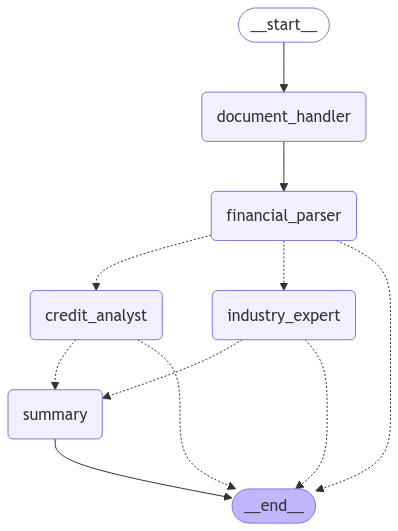

In [62]:
def route_after_financial(state: EarningsAnalysisState):
    """Determine routing after financial analysis"""
    if state["status"] == "financial_analysis_complete":
        return ["credit_analyst", "industry_expert"]
    return "__end__"  # Changed from END to "__end__"

def should_summarize(state: EarningsAnalysisState):
    """Determine if we should move to summary"""
    if state["credit_analysis"] and state["industry_analysis"]:
        return "summary"
    return "__end__"  # Changed from END to "__end__"

# Create workflow
builder = StateGraph(EarningsAnalysisState)

# Add nodes
builder.add_node("document_handler", document_handler_agent)
builder.add_node("financial_parser", financial_parser_agent)
builder.add_node("credit_analyst", credit_analyst_agent)
builder.add_node("industry_expert", industry_expert_agent)
builder.add_node("summary", summary_agent)

# Add edges
builder.add_edge(START, "document_handler")
builder.add_edge("document_handler", "financial_parser")

# Add conditional edges
builder.add_conditional_edges(
    "financial_parser",
    route_after_financial,
    ["credit_analyst", "industry_expert", "__end__"]  # Added "__end__"
)

builder.add_conditional_edges(
    "credit_analyst",
    should_summarize,
    ["summary", "__end__"]  # Added "__end__"
)
builder.add_conditional_edges(
    "industry_expert",
    should_summarize,
    ["summary", "__end__"]  # Added "__end__"
)

builder.add_edge("summary", "__end__")  # Changed from END to "__end__"

# Compile the graph without checkpointer
workflow = builder.compile()

# View the graph
display(Image(workflow.get_graph(xray=1).draw_mermaid_png()))

In [69]:
#Run the analysis
# Initialize state
initial_state = {
    "ticker": "MLTVR",
    "industry": "Digital Education",
    "documents": {},
    "document_analysis": None,
    "financial_analysis": None,
    "credit_analysis": None,
    "industry_analysis": None,
    "final_comment": None,
    "status": "start",
    "errors": []
}

# Run workflow
result = workflow.invoke(initial_state)

Processing documents for MLTVR...

Processing earnings_release...
Successfully loaded 62 pages
Created 237 text chunks
Successfully processed earnings_release

Document processing completed successfully!

Analyzing financial information for MLTVR...

Analyzing: What was the revenue and revenue growth in the most recent quarter?

Analyzing: What were the EBITDA and EBITDA margins?

Analyzing: What was mentioned about traffic or operational metrics?

Analyzing: What is the company's guidance or outlook?

Analyzing: What are the key balance sheet metrics and leverage ratios?

Financial analysis completed successfully!
